### Post Analysis of the paper "Overtrained Language Models Are Harder to Fine-Tune"

https://arxiv.org/pdf/2503.19206


In this paper, the authors argue that one reason more Large Language Models (LLMs) aren’t fine-tuned is that extensive pretraining can cause what they call “catastrophic overtraining.”

Specifically, they show that models pretrained on very large amounts of data (e.g., > ~1.5T tokens) become harder to fine-tune and yield lower improvements or even degrade performance on downstream tasks after fine-tuning.

We can analyze their data on the OLMO-1B model checkpoints using weightwatcher

Doing so, we see that as base model performance improves, the mean alpha decreases.

But in all but 1 case, the fine tuning performance gets worse

In [1]:
import weightwatcher as ww
import torch

print("Torch version:", torch.__version__)
print("MPS is available:", torch.backends.mps.is_available())
print("MPS is built:", torch.backends.mps.is_built())

Running on macOS.


PyTorch is available but CUDA is not. Defaulting to NumPy for SVD
Import error , reetting to svd accurate methods


Running on macOS.
Torch version: 2.6.0
MPS is available: True
MPS is built: True


### Example of how to Analyze OLMO Checkpoints

In [2]:
from hf_olmo import OLMoForCausalLM  

olmo_model = OLMoForCausalLM.from_pretrained("allenai/OLMo-1B", revision="step738000-tokens3095B")

# Define local directory to save HuggingFace-compatible checkpoint
save_directory = "./olmo-1B-step738000-hf"

# Save model and tokenizer
olmo_model.save_pretrained(save_directory)

2025-03-29 21:08:24,399 - INFO - PyTorch version 2.6.0 available.


In [3]:
watcher = ww.WeightWatcher(model=save_directory)
watcher.describe()

2025-03-29 21:08:38,099 - INFO - Opening safetensor handles for files: ./olmo-1B-step738000-hf/model.safetensors
2025-03-29 21:08:38,099 - INFO - Opening : ./olmo-1B-step738000-hf/model.safetensors
2025-03-29 21:08:38,104 - INFO - SafetensorDict initialized with files: ./olmo-1B-step738000-hf/model.safetensors


,layer_id,name,M,N,Q,layer_type,longname,num_evals,rf
0,0,model.transformer.blocks.0.att_proj,2048,6144,3.0,dense,model.transformer.blocks.0.att_proj,2048,1
1,1,model.transformer.blocks.0.attn_out,2048,2048,1.0,dense,model.transformer.blocks.0.attn_out,2048,1
2,2,model.transformer.blocks.0.ff_out,2048,8192,4.0,dense,model.transformer.blocks.0.ff_out,2048,1
3,3,model.transformer.blocks.0.ff_proj,2048,16384,8.0,dense,model.transformer.blocks.0.ff_proj,2048,1
4,4,model.transformer.blocks.1.att_proj,2048,6144,3.0,dense,model.transformer.blocks.1.att_proj,2048,1
...,...,...,...,...,...,...,...,...,...
59,59,model.transformer.blocks.8.ff_proj,2048,16384,8.0,dense,model.transformer.blocks.8.ff_proj,2048,1
60,60,model.transformer.blocks.9.att_proj,2048,6144,3.0,dense,model.transformer.blocks.9.att_proj,2048,1
61,61,model.transformer.blocks.9.attn_out,2048,2048,1.0,dense,model.transformer.blocks.9.attn_out,2048,1
62,62,model.transformer.blocks.9.ff_out,2048,8192,4.0,dense,model.transformer.blocks.9.ff_out,2048,1


In [4]:
df_3T = watcher.analyze(fix_fingers='clip_xmax')

2025-03-29 21:08:38,166 - INFO - Opening safetensor handles for files: ./olmo-1B-step738000-hf/model.safetensors
2025-03-29 21:08:38,167 - INFO - Opening : ./olmo-1B-step738000-hf/model.safetensors
2025-03-29 21:08:38,174 - INFO - SafetensorDict initialized with files: ./olmo-1B-step738000-hf/model.safetensors


### WeightWatcher Analysis of the OLMO-1b Checkpoints

In [10]:
import os
import tempfile
from hf_olmo import OLMoForCausalLM
from transformers import AutoTokenizer
import weightwatcher as ww

# Valid checkpoints and their revisions from allenai/OLMo-1B
checkpoints = [
    ("step117850-tokens494B", "olmo-1B-step117850-hf"),
    ("step358000-tokens1502B", "olmo-1B-step358000-hf"),
    ("step447000-tokens1875B", "olmo-1B-step447000-hf"),
    ("step561250-tokens2354B", "olmo-1B-step561250-hf"),
    ("step738000-tokens3095B", "olmo-1B-step738000-hf")
]

# Iterate over each valid checkpoint
for revision, name in checkpoints:
    print(f"Processing model {revision}")

    with tempfile.TemporaryDirectory() as save_dir:
        # Load model
        model = OLMoForCausalLM.from_pretrained("allenai/OLMo-1B", revision=revision)

        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-1B")

        # Save model and tokenizer locally in temporary directory
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)

        # Run WeightWatcher analysis
        watcher = ww.WeightWatcher(model=save_dir)
        analysis_df = watcher.analyze(fix_fingers='clip_xmax')

        # Save analysis DataFrame as feather file in current directory
        feather_filename = f"{name}-df.feather"
        analysis_df.reset_index(drop=True).to_feather(feather_filename)

        print(f"Analysis complete and saved to {feather_filename}, temporary directory {save_dir} cleaned up automatically.")

print("All valid models processed successfully!")


Processing model step117850-tokens494B


2025-03-29 22:00:54,854 - INFO - Opening safetensor handles for files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmph6vz4hui/model.safetensors
2025-03-29 22:00:54,858 - INFO - Opening : /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmph6vz4hui/model.safetensors
2025-03-29 22:00:54,866 - INFO - SafetensorDict initialized with files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmph6vz4hui/model.safetensors


Analysis complete and saved to olmo-1B-step117850-hf-df.feather, temporary directory /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmph6vz4hui cleaned up automatically.
Processing model step358000-tokens1502B


model.safetensors:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

2025-03-29 22:08:06,650 - INFO - Opening safetensor handles for files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp8fuiuyrk/model.safetensors
2025-03-29 22:08:06,652 - INFO - Opening : /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp8fuiuyrk/model.safetensors
2025-03-29 22:08:06,662 - INFO - SafetensorDict initialized with files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp8fuiuyrk/model.safetensors


Analysis complete and saved to olmo-1B-step358000-hf-df.feather, temporary directory /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp8fuiuyrk cleaned up automatically.
Processing model step447000-tokens1875B


model.safetensors:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

2025-03-29 22:15:32,228 - INFO - Opening safetensor handles for files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp850sn7yn/model.safetensors
2025-03-29 22:15:32,235 - INFO - Opening : /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp850sn7yn/model.safetensors
2025-03-29 22:15:32,240 - INFO - SafetensorDict initialized with files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp850sn7yn/model.safetensors


Analysis complete and saved to olmo-1B-step447000-hf-df.feather, temporary directory /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp850sn7yn cleaned up automatically.
Processing model step561250-tokens2354B


2025-03-29 22:20:04,990 - INFO - Opening safetensor handles for files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp6tod3szv/model.safetensors
2025-03-29 22:20:04,994 - INFO - Opening : /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp6tod3szv/model.safetensors
2025-03-29 22:20:05,001 - INFO - SafetensorDict initialized with files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp6tod3szv/model.safetensors


Analysis complete and saved to olmo-1B-step561250-hf-df.feather, temporary directory /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmp6tod3szv cleaned up automatically.
Processing model step738000-tokens3095B


2025-03-29 22:24:01,983 - INFO - Opening safetensor handles for files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmpexwuna3g/model.safetensors
2025-03-29 22:24:01,987 - INFO - Opening : /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmpexwuna3g/model.safetensors
2025-03-29 22:24:01,998 - INFO - SafetensorDict initialized with files: /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmpexwuna3g/model.safetensors


Analysis complete and saved to olmo-1B-step738000-hf-df.feather, temporary directory /var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/tmpexwuna3g cleaned up automatically.
All valid models processed successfully!


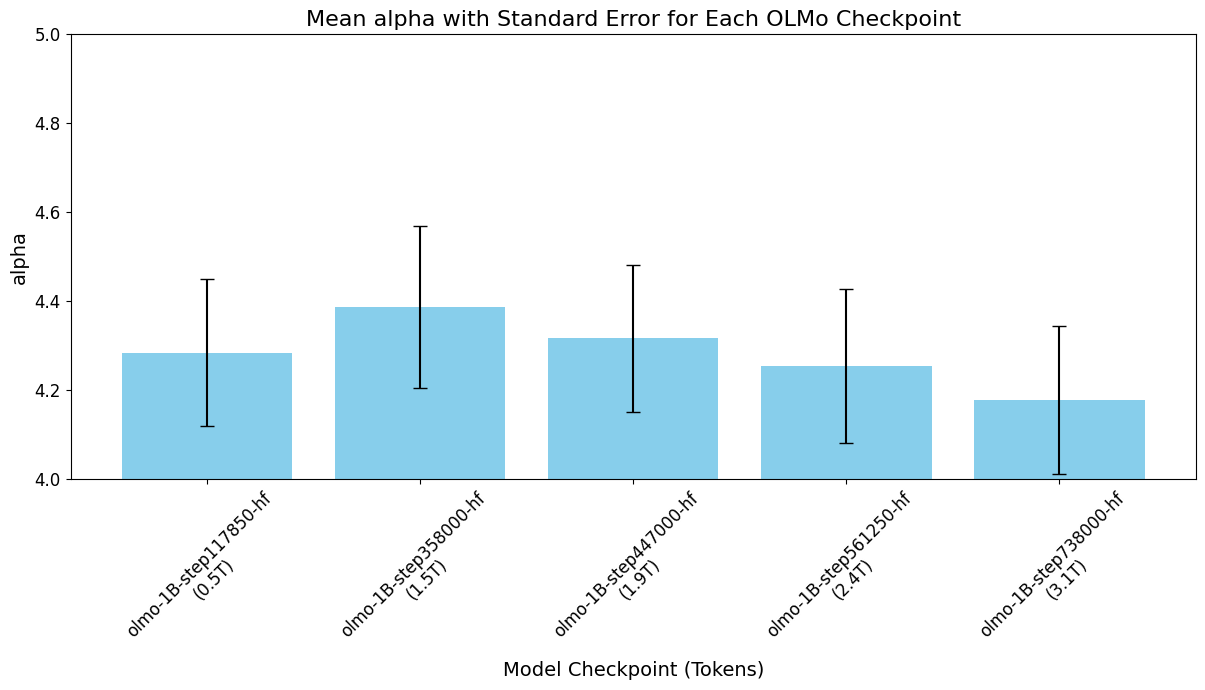

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

means = []
standard_errors = []
names = []
token_labels = {
    "step10000": "0.04T",
    "step117850": "0.5T",
    "step358000": "1.5T",
    "step447000": "1.9T",
    "step561250": "2.4T",
    "step738000": "3.1T",
}

alpha = 'alpha'
# Load data and compute statistics
for revision, name in checkpoints:
    feather_filename = f"{name}-df.feather"
    df = pd.read_feather(feather_filename)
    
    alpha_mean = df[alpha].mean()
    alpha_se = df[alpha].std() / np.sqrt(len(df))

    means.append(alpha_mean)
    standard_errors.append(alpha_se)
    
    # Extract step from revision for labeling
    step = revision.split('-')[0]
    token_label = token_labels.get(step, "")
    names.append(f"{name}\n({token_label})")

# Plot bar chart with standard error bars and token labels
plt.figure(figsize=(12, 7))
bars = plt.bar(names, means, yerr=standard_errors, capsize=5, color='skyblue')

plt.ylabel(f'{alpha}', fontsize=14)
plt.xlabel('Model Checkpoint (Tokens)', fontsize=14)
plt.title(f'Mean {alpha} with Standard Error for Each OLMo Checkpoint', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.ylim(4,5)

plt.show()

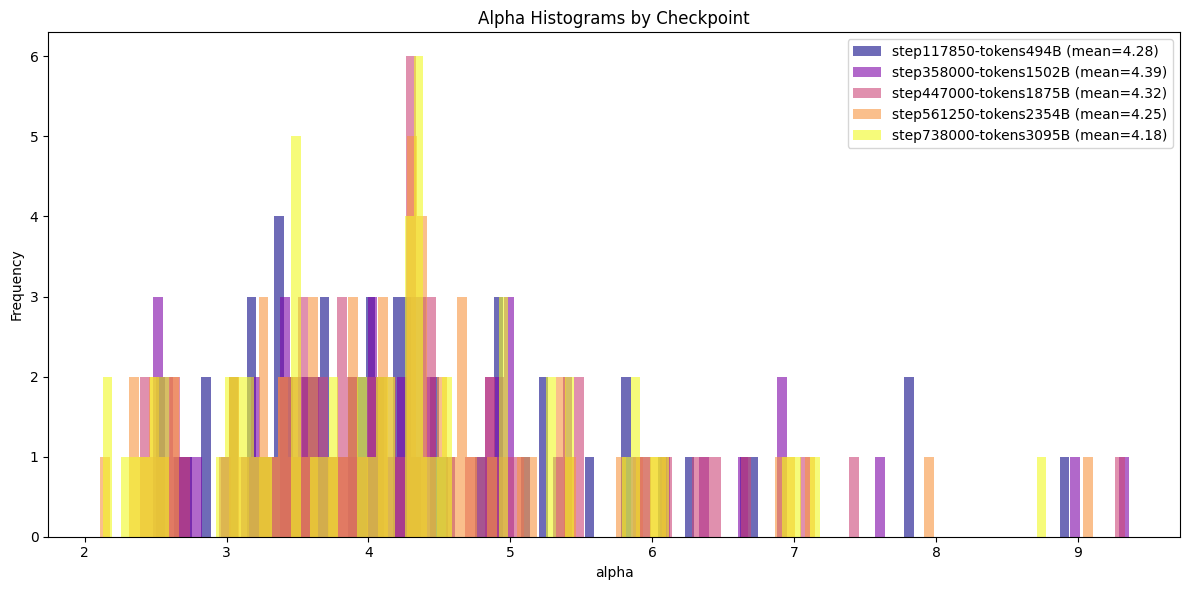

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

checkpoints = [
    ("step117850-tokens494B", "olmo-1B-step117850-hf"),
    ("step358000-tokens1502B", "olmo-1B-step358000-hf"),
    ("step447000-tokens1875B", "olmo-1B-step447000-hf"),
    ("step561250-tokens2354B", "olmo-1B-step561250-hf"),
    ("step738000-tokens3095B", "olmo-1B-step738000-hf")
]

# Use a perceptually uniform colormap like 'plasma' or 'viridis'
cmap = cm.get_cmap("plasma", len(checkpoints))

plt.figure(figsize=(12, 6))

for i, (revision, name) in enumerate(checkpoints):
    feather_filename = f"{name}-df.feather"
    df = pd.read_feather(feather_filename)
    mean = df.alpha.mean()
    color = cmap(i)  # Get color from colormap
    df.alpha.plot.hist(
        bins=100,
        label=f"{revision} (mean={mean:.2f})",
        color=color,
        alpha=0.6
    )

plt.legend()
plt.xlabel("alpha")
plt.ylabel("Frequency")
plt.title("Alpha Histograms by Checkpoint")
plt.tight_layout()
plt.show()


### Data has been extracted from the paper into 

OLMO1B_Fine_Tuning_Results.csv


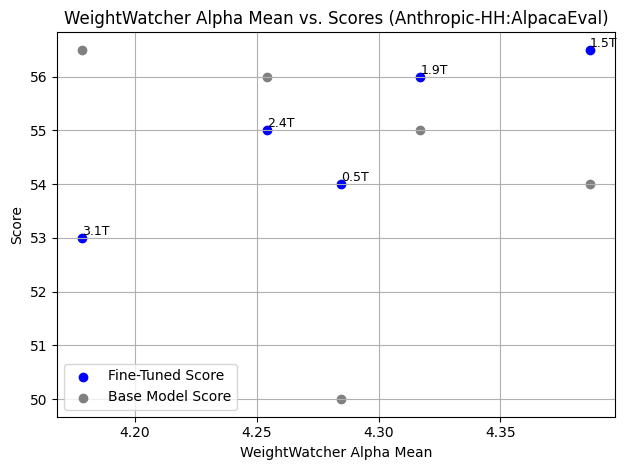

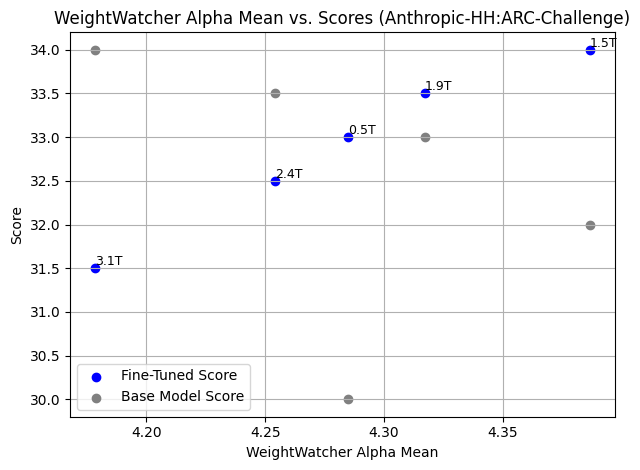

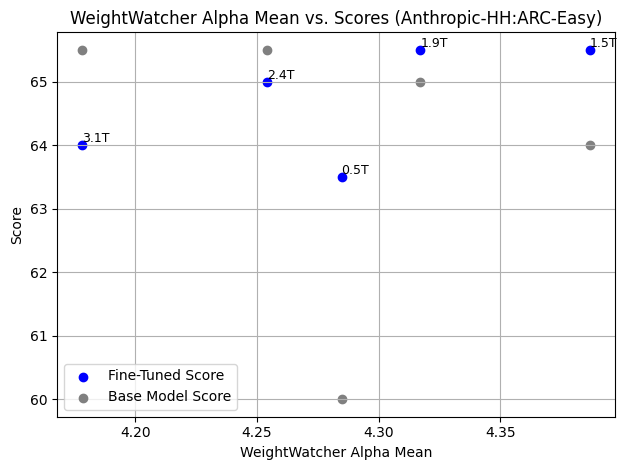

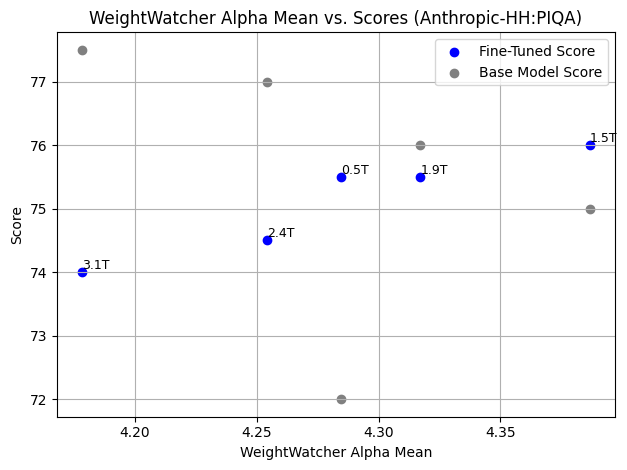

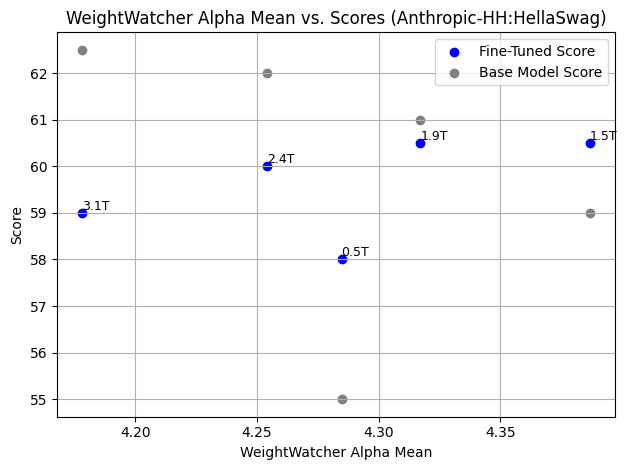

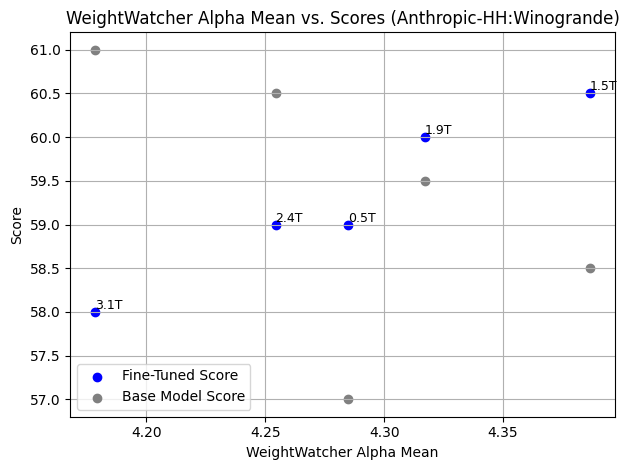

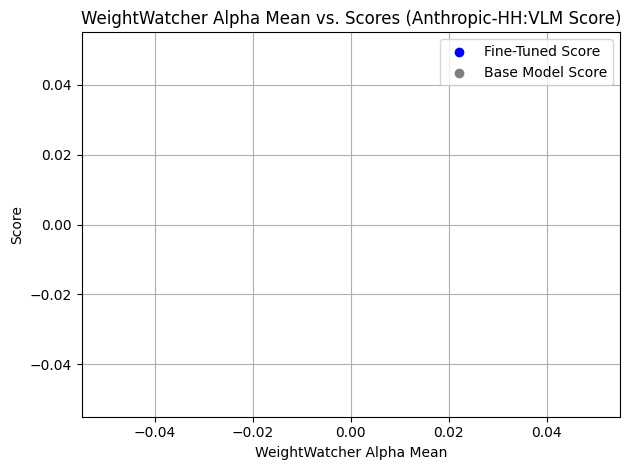

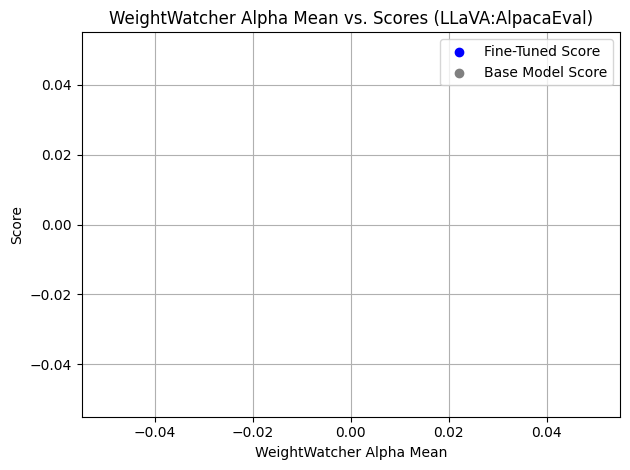

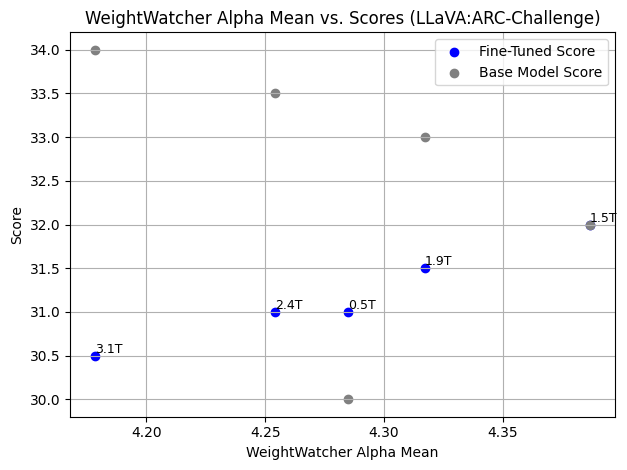

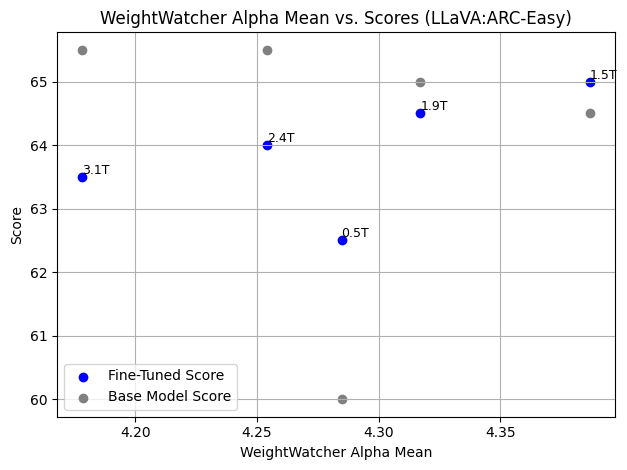

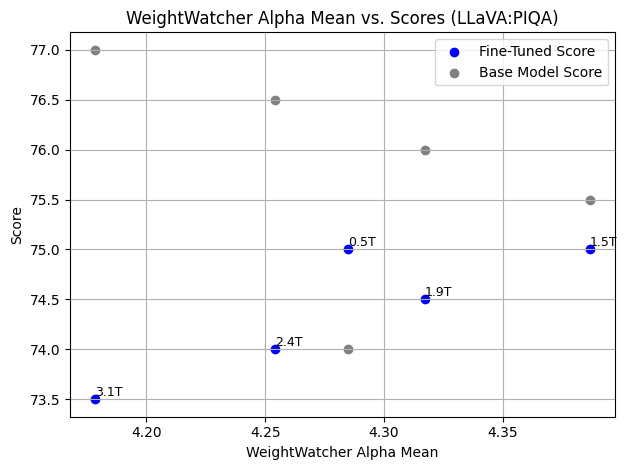

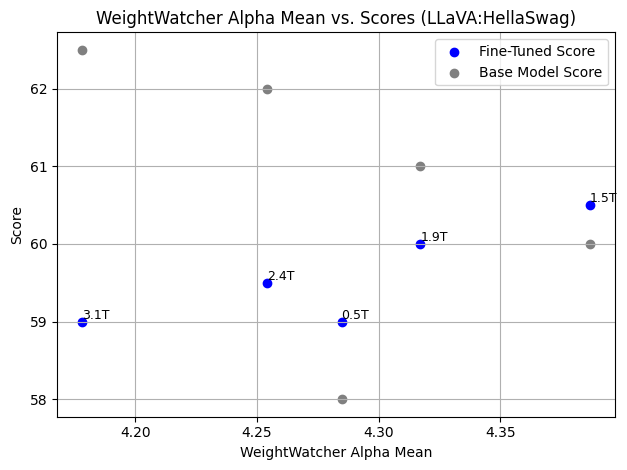

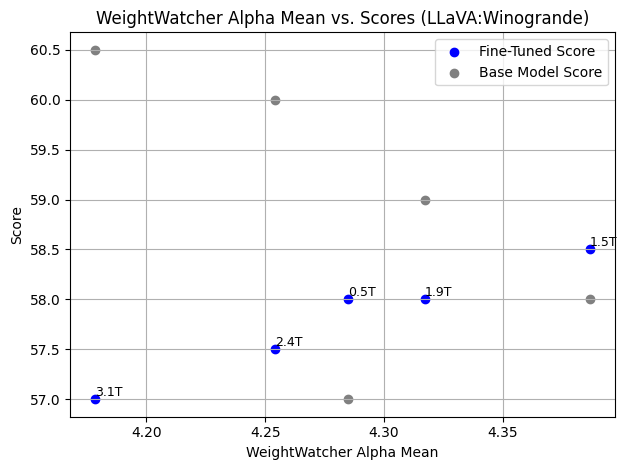

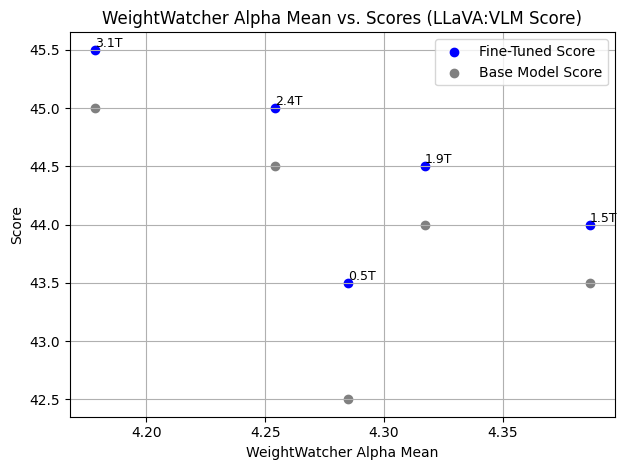

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Previously computed WeightWatcher alpha values
alpha_data = []
checkpoints = [
    ("olmo-1B-step117850-hf", "0.5T"),
    ("olmo-1B-step358000-hf", "1.5T"),
    ("olmo-1B-step447000-hf", "1.9T"),
    ("olmo-1B-step561250-hf", "2.4T"),
    ("olmo-1B-step738000-hf", "3.1T")
]

for name, token_label in checkpoints:
    feather_filename = f"{name}-df.feather"
    df = pd.read_feather(feather_filename)
    alpha_mean = df['alpha'].mean()
    alpha_data.append({'Token_Count': token_label, 'Alpha_Mean': alpha_mean})

alpha_df = pd.DataFrame(alpha_data)

# Load fine-tuning results dataframe (previously extracted)
fine_tune_df = pd.read_csv("OLMO1B_Fine_Tuning_Results.csv")  # or load it from the previous step if already available

# Merge alpha means with fine-tuning results
merged_df = pd.merge(fine_tune_df, alpha_df, on="Token_Count")

# Plot the relationship between Alpha and Fine-Tuned Scores for each task
unique_tasks = merged_df['Task'].unique()


datasets = ['Anthropic-HH', 'LLaVA']
for dataset in datasets:
    
    for task in unique_tasks:
        task_df = merged_df[merged_df['Task'] == task]
        task_df = task_df[task_df.Fine_Tuning==dataset]
        
        plt.scatter(task_df['Alpha_Mean'], task_df['Fine_Tuned_Score'], color='blue', label='Fine-Tuned Score')
        plt.scatter(task_df['Alpha_Mean'], task_df['Base_Model_Score'], color='gray', label='Base Model Score')
    
        for i, row in task_df.iterrows():
            plt.text(row['Alpha_Mean'], row['Fine_Tuned_Score'], row['Token_Count'], fontsize=9, verticalalignment='bottom')
            #plt.text(row['Alpha_Mean'], row['Base_Model_Score'], row['Token_Count'], fontsize=9, verticalalignment='bottom')
    
        plt.title(f"WeightWatcher Alpha Mean vs. Scores ({dataset}:{task})")
        plt.xlabel("WeightWatcher Alpha Mean")
        plt.ylabel("Score")
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()


No data available for dataset: Anthropic-HH, task: VLM Score. Skipping plot.
No data available for dataset: LLaVA, task: AlpacaEval. Skipping plot.


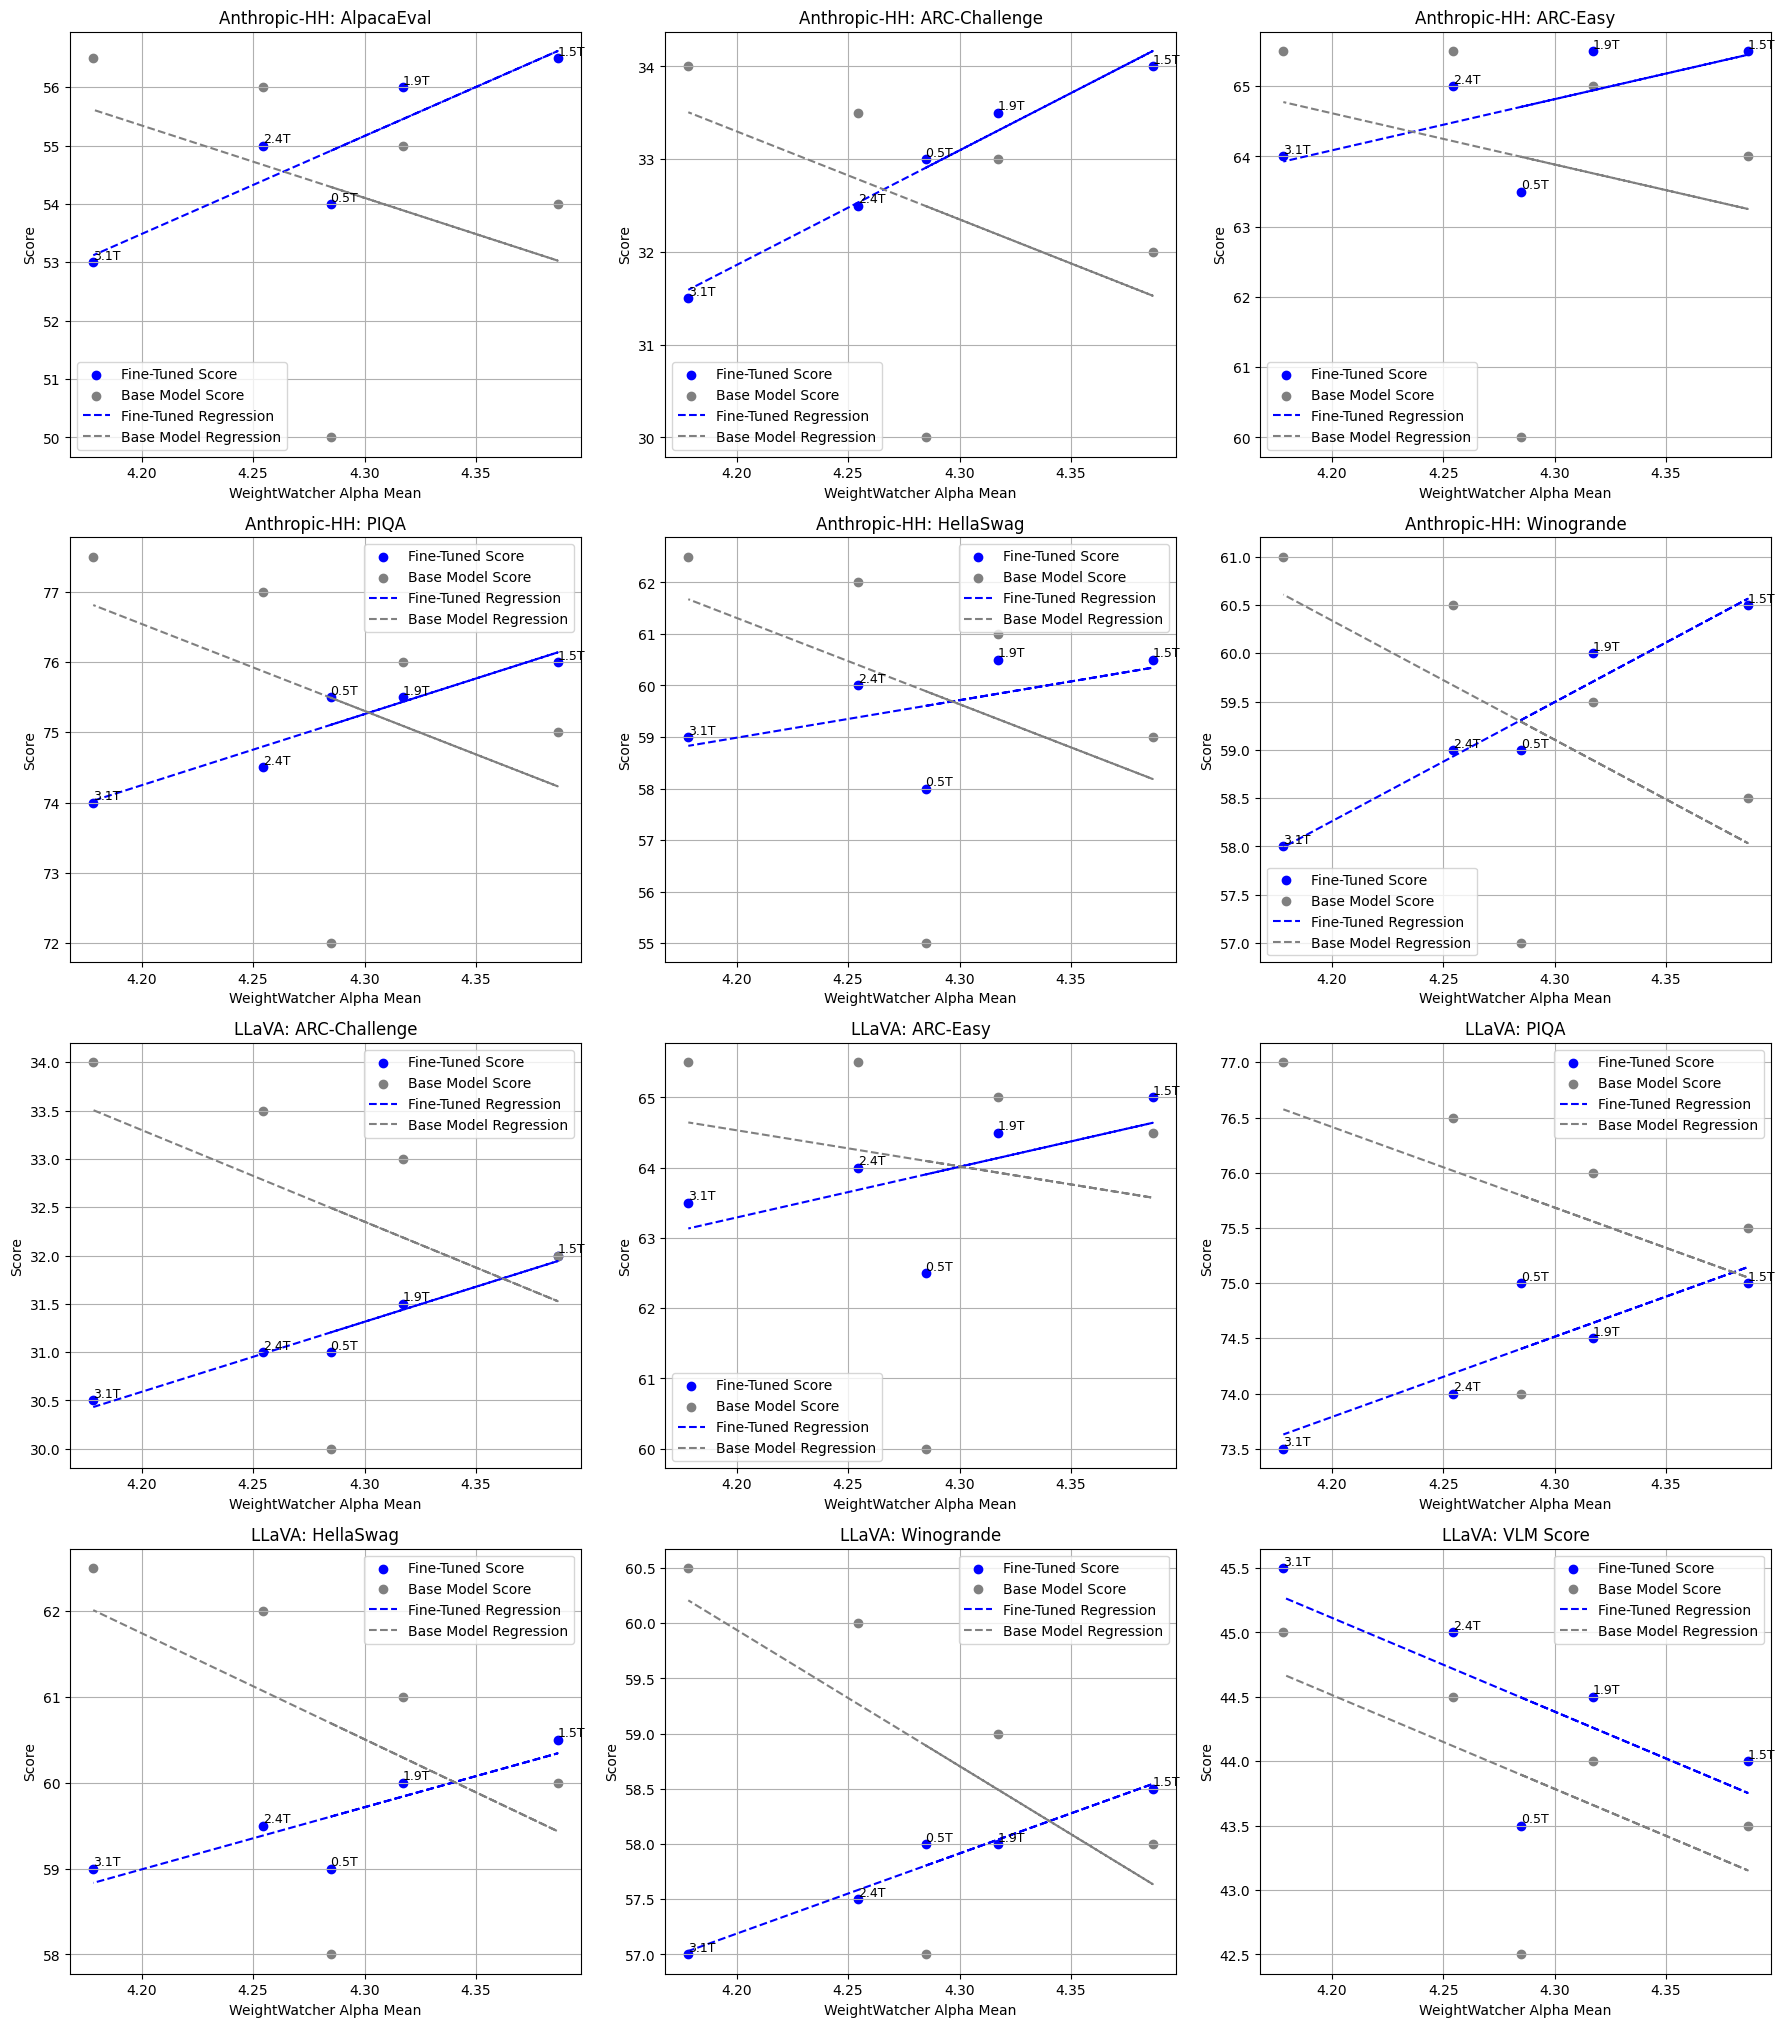

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Previously computed WeightWatcher alpha values
alpha_data = []
checkpoints = [
    ("olmo-1B-step117850-hf", "0.5T"),
    ("olmo-1B-step358000-hf", "1.5T"),
    ("olmo-1B-step447000-hf", "1.9T"),
    ("olmo-1B-step561250-hf", "2.4T"),
    ("olmo-1B-step738000-hf", "3.1T")
]

for name, token_label in checkpoints:
    feather_filename = f"{name}-df.feather"
    df = pd.read_feather(feather_filename)
    alpha_mean = df['alpha'].mean()
    alpha_data.append({'Token_Count': token_label, 'Alpha_Mean': alpha_mean})

alpha_df = pd.DataFrame(alpha_data)

# Load fine-tuning results dataframe (previously extracted)
fine_tune_df = pd.read_csv("OLMO1B_Fine_Tuning_Results.csv")  # or load it from the previous step if already available

# Merge alpha means with fine-tuning results
merged_df = pd.merge(fine_tune_df, alpha_df, on="Token_Count")

# Plot the relationship between Alpha and Fine-Tuned Scores for each task
unique_tasks = merged_df['Task'].unique()
datasets = ['Anthropic-HH', 'LLaVA']

num_plots = len(datasets) * len(unique_tasks)
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

plot_idx = 0

for dataset in datasets:
    for task in unique_tasks:
        task_df = merged_df[(merged_df['Task'] == task) & (merged_df['Fine_Tuning'] == dataset)]

        if task_df.empty:
            print(f"No data available for dataset: {dataset}, task: {task}. Skipping plot.")
            continue

        ax = axes[plot_idx]
        plot_idx += 1

        ax.scatter(task_df['Alpha_Mean'], task_df['Fine_Tuned_Score'], color='blue', label='Fine-Tuned Score')
        ax.scatter(task_df['Alpha_Mean'], task_df['Base_Model_Score'], color='gray', label='Base Model Score')

        # Linear regression for fine-tuned scores
        slope_ft, intercept_ft, _, _, _ = linregress(task_df['Alpha_Mean'], task_df['Fine_Tuned_Score'])
        x_vals = np.array(task_df['Alpha_Mean'])
        ax.plot(x_vals, intercept_ft + slope_ft * x_vals, color='blue', linestyle='--', label='Fine-Tuned Regression')

        # Linear regression for base model scores
        slope_base, intercept_base, _, _, _ = linregress(task_df['Alpha_Mean'], task_df['Base_Model_Score'])
        ax.plot(x_vals, intercept_base + slope_base * x_vals, color='gray', linestyle='--', label='Base Model Regression')

        for i, row in task_df.iterrows():
            ax.text(row['Alpha_Mean'], row['Fine_Tuned_Score'], row['Token_Count'], fontsize=9, verticalalignment='bottom')

        ax.set_title(f"{dataset}: {task}")
        ax.set_xlabel("WeightWatcher Alpha Mean")
        ax.set_ylabel("Score")
        ax.grid(True)
        ax.legend()

# Remove any unused subplots
for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()
